# Woe Binning

Курс: "Матетичне моделювання в R"

---

In [1]:
# install.packages("openxlsx")

package 'openxlsx' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	D:\Temp\Rtmp6NzC2e\downloaded_packages


## Набір даних

Джерело: <https://github.com/gastonstat/CreditScoring/blob/master/CleanCreditScoring.csv>

Завантажимо дані:

In [6]:
library(openxlsx)
data <- openxlsx::read.xlsx("data/CreditScoring.xlsx", sheet = 1, startRow = 1, colNames = TRUE, rowNames = FALSE)
str(data)

'data.frame':	4446 obs. of  16 variables:
 $ Status   : chr  "good" "good" "bad" "good" ...
 $ Seniority: num  9 17 10 0 0 1 29 9 0 0 ...
 $ Home     : chr  "rent" "rent" "owner" "rent" ...
 $ Time     : num  60 60 36 60 36 60 60 12 60 48 ...
 $ Age      : num  30 58 46 24 26 36 44 27 32 41 ...
 $ Marital  : chr  "married" "widow" "married" "single" ...
 $ Records  : chr  "no_rec" "no_rec" "yes_rec" "no_rec" ...
 $ Job      : chr  "freelance" "fixed" "freelance" "fixed" ...
 $ Expenses : num  73 48 90 63 46 75 75 35 90 90 ...
 $ Income   : num  129 131 200 182 107 214 125 80 107 80 ...
 $ Assets   : num  0 0 3000 2500 0 3500 10000 0 15000 0 ...
 $ Debt     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Amount   : num  800 1000 2000 900 310 650 1600 200 1200 1200 ...
 $ Price    : num  846 1658 2985 1325 910 ...
 $ Finrat   : num  94.6 60.3 67 67.9 34.1 ...
 $ Savings  : num  4.2 4.98 1.98 7.93 7.08 ...


Опишемо дані:

- [x] `Status` - credit status (`Target`)
- [x] `Seniority` job seniority (years)
- [x] `Home` type of home ownership
- [x] `Time` time of requested loan
- [x] `Age` client’s age
- [x] `Marital` marital status
- [x] `Records` existance of records
- [x] `Job` type of job
- [x] `Expenses` amount of expenses
- [x] `Income` amount of income
- [x] `Assets` amount of assets
- [x] `Debt` amount of debt
- [x] `Amount` amount requested of loan
- [x] `Price` price of good

---

## Простий бінінг змінних

### Категоріальна змінна

Створимо дата-фрейм для зберігання інформації про групи змінної `Home` (як приклад біннігу категоріального показника):

In [12]:
home_groups <- data.frame(Group = unique(data$Home), 
                          Good = c(0), Bad = c(0), 
                          GoodP = c(0), BadP = c(0),
                          WOE = c(0), IV = c(0))
home_groups

Group,Good,Bad,GoodP,BadP,WOE,IV
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rent,0,0,0,0,0,0
owner,0,0,0,0,0,0
parents,0,0,0,0,0,0
priv,0,0,0,0,0,0
other,0,0,0,0,0,0
ignore,0,0,0,0,0,0


Переглянемо можливі варіанти показника `Status`, який є залежною бінарною змінною поточної задачі:

In [11]:
library(gmodels)
CrossTable(data$Status)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  4446 

 
          |       bad |      good | 
          |-----------|-----------|
          |      1249 |      3197 | 
          |     0.281 |     0.719 | 
          |-----------|-----------|



 


Сформуємо групи та обчислимо значення по кожній групі:

In [14]:
for(i in 1:nrow(home_groups)) {
  
  group <- home_groups$Group[i]
  
  home_groups$Good[i] <- nrow(data[data$Home == group & data$Status == "good", ])
  home_groups$Bad[i] <- nrow(data[data$Home == group & data$Status == "bad", ])
  
  home_groups$GoodP[i] <- home_groups$Good[i]/nrow(data[data$Status == "good", ])
  home_groups$BadP[i] <- home_groups$Bad[i]/nrow(data[data$Status == "bad", ])
  
  home_groups$WOE[i] <- log( home_groups$GoodP[i] / home_groups$BadP[i])
  home_groups$IV[i] <- (home_groups$GoodP[i] - home_groups$BadP[i])*home_groups$WOE[i]
}

home_groups

Group,Good,Bad,GoodP,BadP,WOE,IV
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rent,585,388,0.182984048,0.310648519,-0.52926313,0.067568098
owner,1716,390,0.536753206,0.312249800,0.54173490,0.121621331
parents,550,232,0.172036284,0.185748599,-0.07668873,0.001051580
priv,162,84,0.050672505,0.067253803,-0.28309010,0.004694001
other,173,146,0.054113231,0.116893515,-0.77018467,0.048352412
ignore,11,9,0.003440726,0.007205765,-0.73919894,0.002783113


Переглянемо сумарний `IV`:

In [17]:
home_iv <- sum(home_groups$IV)
home_iv

[1] 0.2460705

Візуалізуємо групи:

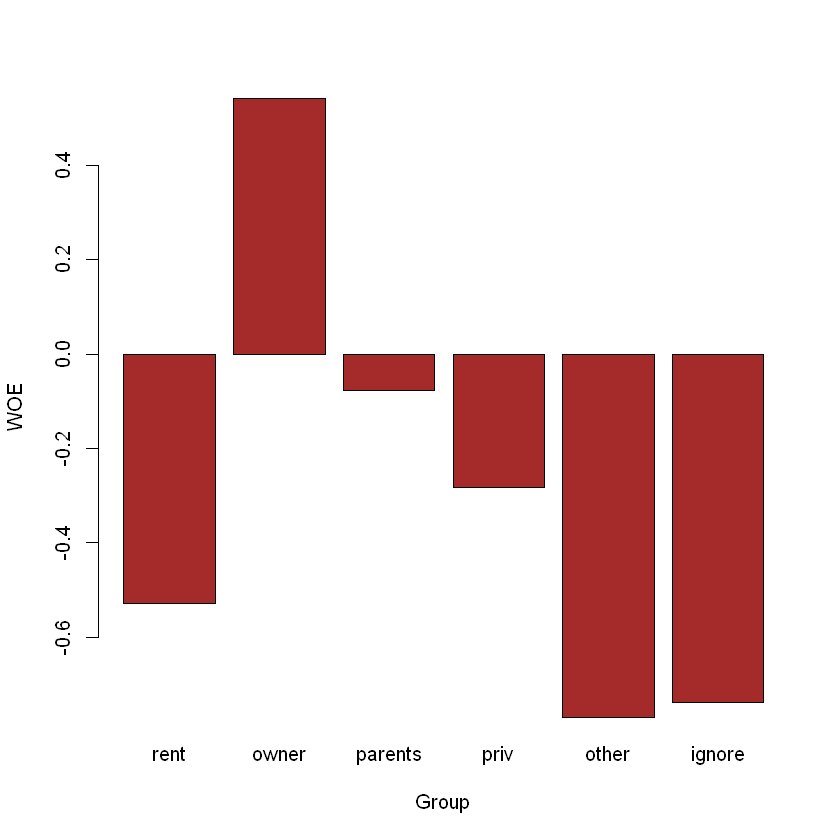

In [20]:
barplot(home_groups$WOE, 
        col="brown", 
        names.arg=c(as.character(home_groups$Group)), 
        xlab="Group",
        ylab="WOE"
)

Створимо датафрейм для нових `WOE`-даних:

In [22]:
new_df <- data.frame(Status = data$Status, Home = data$Home, HomeWoe = c(0))

Замінимо значення на `WOE`:

In [26]:
for(i in 1:nrow(home_groups)) {
  group <- home_groups$Group[i]
  woe <- home_groups$WOE[i]  
  new_df[new_df$Home == group, ]$HomeWoe <- woe
}

tail(new_df)

,Status,Home,HomeWoe
,<chr>,<chr>,<dbl>
4441,bad,other,-0.7701847
4442,bad,rent,-0.5292631
4443,good,owner,0.5417349
4444,bad,owner,0.5417349
4445,good,rent,-0.5292631
4446,good,owner,0.5417349


---

### Числова змінна

Обрахуємо приклад числовиго показника (на прикладі `Age`):

In [36]:
min_age <- min(data$Age)
max_age <- max(data$Age)

step <- round(max_age - min_age)/10


age_groups <- data.frame(Min = seq(min_age, max_age-step, step), 
                         Max = seq(min_age + step, max_age, step), 
                          Good = c(0), Bad = c(0), 
                          GoodP = c(0), BadP = c(0),
                          WOE = c(0), IV = c(0))

age_groups

Min,Max,Good,Bad,GoodP,BadP,WOE,IV
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,23,0,0,0,0,0,0
23,28,0,0,0,0,0,0
28,33,0,0,0,0,0,0
33,38,0,0,0,0,0,0
38,43,0,0,0,0,0,0
43,48,0,0,0,0,0,0
48,53,0,0,0,0,0,0
53,58,0,0,0,0,0,0
58,63,0,0,0,0,0,0


Сформуємо групи:

In [37]:
for(i in 1:nrow(age_groups)) {
  
  min <- age_groups$Min[i]
  max<- age_groups$Max[i]
  
  age_groups$Good[i] <- nrow(data[data$Age >= min & data$Age < max & data$Status == "good", ])
  age_groups$Bad[i] <- nrow(data[data$Age >= min & data$Age < max & data$Status == "bad", ])
  
  if(i == nrow(age_groups)) {
    age_groups$Good[i] <- age_groups$Good[i] + nrow(data[data$Age == max & data$Status == "good", ])
    age_groups$Bad[i] <- age_groups$Bad[i] + nrow(data[data$Age == max & data$Status == "bad", ])
  }
  
  age_groups$GoodP[i] <- age_groups$Good[i]/nrow(data[data$Status == "good", ])
  age_groups$BadP[i] <- age_groups$Bad[i]/nrow(data[data$Status == "bad", ])
  
  age_groups$WOE[i] <- log( age_groups$GoodP[i] / age_groups$BadP[i])
  
  age_groups$IV[i] <- (age_groups$GoodP[i] - age_groups$BadP[i]) * age_groups$WOE[i]
}

age_groups

Min,Max,Good,Bad,GoodP,BadP,WOE,IV
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,23,169,110,0.05286206,0.088070456,-0.51045129,0.0179721723
23,28,505,231,0.15796059,0.184947958,-0.15772892,0.0042566888
28,33,564,213,0.17641539,0.170536429,0.03389245,0.0001992523
33,38,491,212,0.15358148,0.169735789,-0.10001179,0.0016156210
38,43,443,183,0.13856741,0.146517214,-0.05578602,0.0004434881
43,48,320,123,0.10009384,0.098478783,0.01626700,0.0000262721
48,53,317,79,0.09915546,0.063250600,0.44958428,0.0161422597
53,58,214,58,0.06693775,0.046437150,0.36566337,0.0074963200
58,63,124,31,0.03878636,0.024819856,0.44642472,0.0062349937


Сумарний IV:

In [38]:
age_iv <- sum(age_groups$IV)
age_iv

[1] 0.06092274

Візуалізуємо значення груп `WOE`:

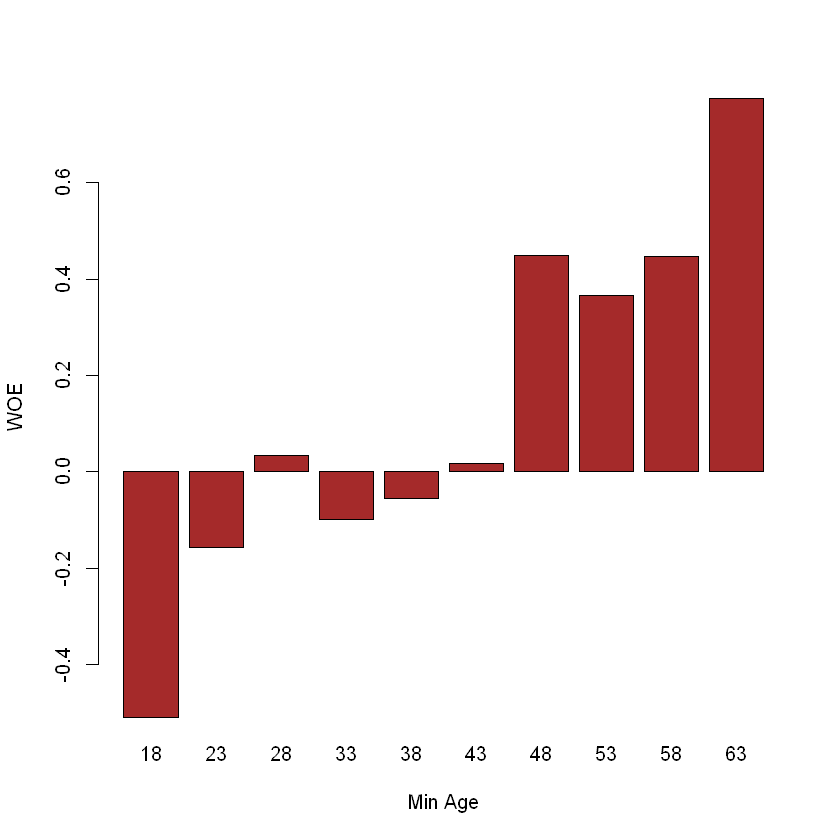

In [41]:
barplot(age_groups$WOE, 
        col="brown", 
        names.arg=c(age_groups$Min), 
        xlab="Min Age",
        ylab="WOE"
)

Замінимо значення на `WOE`:

In [43]:
new_df$Age <- data$Age
new_df$AgeWoe <- c(0)

for(i in 1:nrow(age_groups)) {
  
  min <- age_groups$Min[i]
  max <- age_groups$Max[i]
  woe <- age_groups$WOE[i]
  
  new_df[new_df$Age >= min & new_df$Age < max, ]$AgeWoe <- woe
  
  if(i == nrow(age_groups)) {
    new_df$AgeWoe[i] <- woe
  }
  
}

head(new_df)

,Status,Home,HomeWoe,Age,AgeWoe
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,good,rent,-0.5292631,30,0.03389245
2,good,rent,-0.5292631,58,0.44642472
3,bad,owner,0.5417349,46,0.01626700
4,good,rent,-0.5292631,24,-0.15772892
5,good,rent,-0.5292631,26,-0.15772892
6,good,owner,0.5417349,36,-0.10001179


Видалимо оригінальні значення з набору даних:

In [44]:
new_df$Home <- NULL
new_df$Age <- NULL
head(new_df)

,Status,HomeWoe,AgeWoe
,<chr>,<dbl>,<dbl>
1,good,-0.5292631,0.03389245
2,good,-0.5292631,0.44642472
3,bad,0.5417349,0.01626700
4,good,-0.5292631,-0.15772892
5,good,-0.5292631,-0.15772892
6,good,0.5417349,-0.10001179


---

## Бінінг з використанням `woeBin`

---

## Бінінг з використанням `rBin`

---

## Бінінг з використанням `smbinning`

---

## Бінінг з використанням `scorecard`

---